In [1]:
import tensorflow as tf
import keras

### Dataset preparation for the classifiers

In [2]:
CLASS_NAMES = [
    "ADI",
    "BACK",
    "DEB",
    "LYM",
    "MUC",
    "MUS",
    "NORM",
    "STR",
    "TUM",
]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "NCT-CRC-HE-small",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "NCT-CRC-HE-small",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.3,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 6300 files belonging to 9 classes.
Using 4410 files for training.
Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Found 6300 files belonging to 9 classes.
Using 1890 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "CRC-VAL-HE-7K",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

Found 7180 files belonging to 9 classes.


### Classifiers

https://keras.io/api/applications/

#### ResNet50

In [3]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 

# freeze the base model
base_model.trainable = False

# create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(9, activation="softmax")(x)
model = keras.Model(inputs, outputs)

# fine-tune the model
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

# train the model
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

Epoch 1/10


2023-04-15 11:18:24.788794: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


138/138 [==============================] - 22s 131ms/step - loss: 0.5727 - accuracy: 0.8127 - auc: 0.9805 - precision: 0.9116 - recall: 0.7206 - val_loss: 0.3583 - val_accuracy: 0.8836 - val_auc: 0.9918 - val_precision: 0.9235 - val_recall: 0.8434
Epoch 2/10
138/138 [==============================] - 15s 111ms/step - loss: 0.2698 - accuracy: 0.9184 - auc: 0.9954 - precision: 0.9420 - recall: 0.8905 - val_loss: 0.2776 - val_accuracy: 0.9164 - val_auc: 0.9948 - val_precision: 0.9373 - val_recall: 0.8857
Epoch 3/10
138/138 [==============================] - 15s 110ms/step - loss: 0.2101 - accuracy: 0.9347 - auc: 0.9972 - precision: 0.9551 - recall: 0.9166 - val_loss: 0.2547 - val_accuracy: 0.9185 - val_auc: 0.9950 - val_precision: 0.9444 - val_recall: 0.8989
Epoch 4/10
138/138 [==============================] - 15s 110ms/step - loss: 0.1741 - accuracy: 0.9472 - auc: 0.9981 - precision: 0.9607 - recall: 0.9324 - val_loss: 0.2361 - val_accuracy: 0.9259 - val_auc: 0.9955 - val_precision: 0.9

In [20]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________


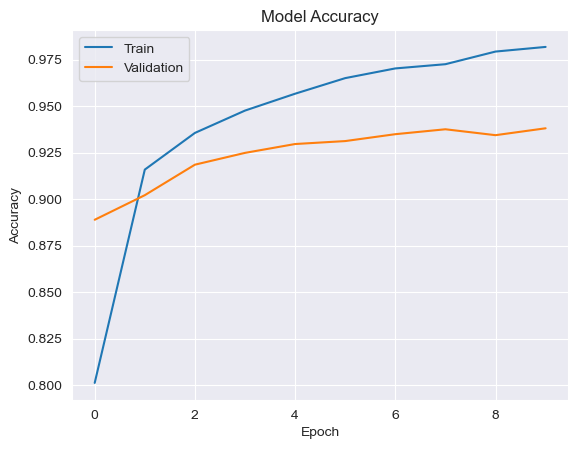

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")


plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

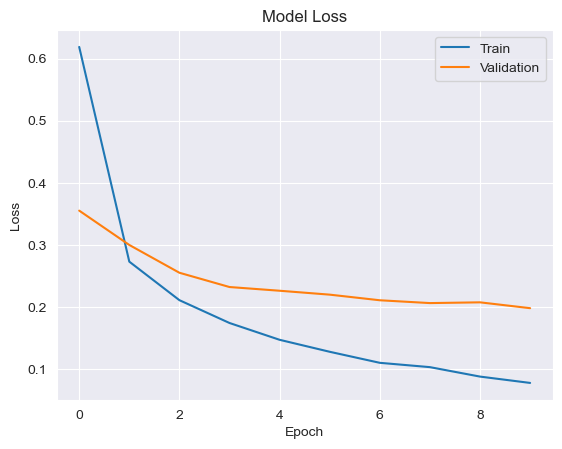

In [13]:
# display loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [6]:
model.save("models/resnet_50_10e.h5")

#### VGG16

In [14]:
base_model_vgg = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False) 

# freeze the base model
base_model_vgg.trainable = False

# create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model_vgg(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(9, activation="softmax")(x)
model_vgg = keras.Model(inputs, outputs)

# fine-tune the model
model_vgg.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

# train the model
history_vgg = model_vgg.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

58889256/58889256 [==============================] - 22s 0us/step
Epoch 1/10
138/138 [==============================] - 26s 183ms/step - loss: 1.5789 - accuracy: 0.6143 - auc: 0.8980 - precision: 0.6587 - recall: 0.5846 - val_loss: 0.7886 - val_accuracy: 0.7672 - val_auc: 0.9614 - val_precision: 0.7965 - val_recall: 0.7497
Epoch 2/10
138/138 [==============================] - 25s 178ms/step - loss: 0.5106 - accuracy: 0.8447 - auc: 0.9801 - precision: 0.8655 - recall: 0.8256 - val_loss: 0.5648 - val_accuracy: 0.8397 - val_auc: 0.9770 - val_precision: 0.8612 - val_recall: 0.8243
Epoch 3/10
138/138 [==============================] - 24s 176ms/step - loss: 0.3756 - accuracy: 0.8755 - auc: 0.9885 - precision: 0.8917 - recall: 0.8628 - val_loss: 0.4799 - val_accuracy: 0.8619 - val_auc: 0.9813 - val_precision: 0.8784 - val_recall: 0.8487
Epoch 4/10
138/138 [==============================] - 24s 177ms/step - loss: 0.2901 - accuracy: 0.9029 - auc: 0.9921 - precision: 0.9167 - recall: 0.8907 - v

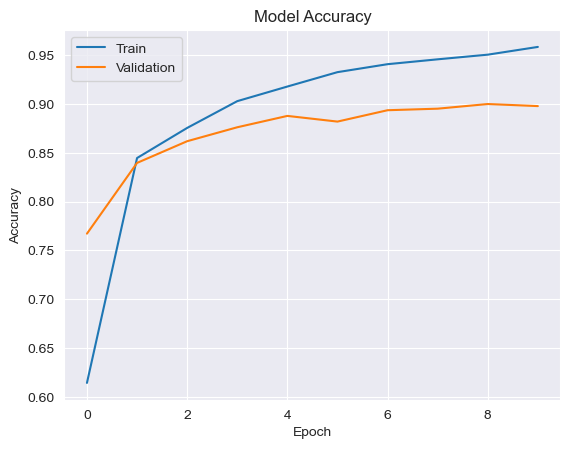

In [15]:
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

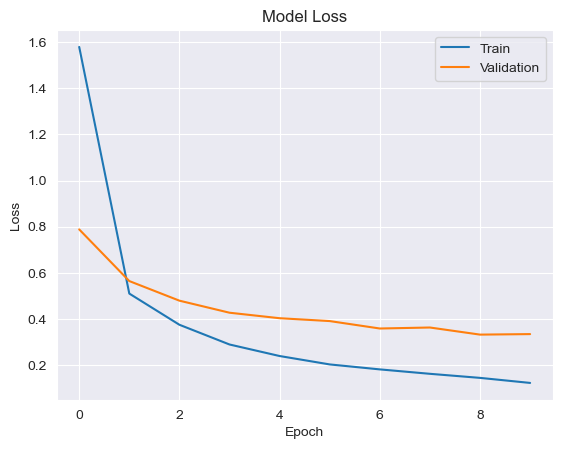

In [17]:
plt.plot(history_vgg.history["loss"])
plt.plot(history_vgg.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [18]:
model_vgg.save("models/vgg_16_10e.h5")

In [22]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "CRC-VAL-HE-7K",
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

model.evaluate(test_ds)

Found 7180 files belonging to 9 classes.
225/225 [==============================] - 18s 81ms/step - loss: 0.3652 - accuracy: 0.8648 - auc: 0.9897 - precision: 0.8788 - recall: 0.8522


[0.3651573956012726,
 0.8647632598876953,
 0.9897357821464539,
 0.8787878751754761,
 0.8522284626960754]

#### DenseNet121

In [5]:
base_model_densenet121 = tf.keras.applications.DenseNet121(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

# freeze the base model
base_model_densenet121.trainable = False

# create a new model on top
inputs = keras.Input(shape=(224, 224, 3))

x = base_model_densenet121(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(9, activation="softmax")(x)
model_densenet121 = keras.Model(inputs, outputs)

# fine-tune the model
model_densenet121.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

# train the model
history_densenet121 = model_densenet121.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)


Epoch 1/10
138/138 [==============================] - 24s 150ms/step - loss: 1.7980 - accuracy: 0.5315 - auc: 0.8638 - precision: 0.6150 - recall: 0.4608 - val_loss: 0.9886 - val_accuracy: 0.6582 - val_auc: 0.9412 - val_precision: 0.7362 - val_recall: 0.5656
Epoch 2/10
138/138 [==============================] - 15s 111ms/step - loss: 0.8258 - accuracy: 0.7084 - auc: 0.9576 - precision: 0.7806 - recall: 0.6308 - val_loss: 0.8954 - val_accuracy: 0.6794 - val_auc: 0.9506 - val_precision: 0.7716 - val_recall: 0.6042
Epoch 3/10
138/138 [==============================] - 15s 108ms/step - loss: 0.6777 - accuracy: 0.7642 - auc: 0.9699 - precision: 0.8247 - recall: 0.6975 - val_loss: 0.6911 - val_accuracy: 0.7556 - val_auc: 0.9688 - val_precision: 0.8132 - val_recall: 0.6794
Epoch 4/10
138/138 [==============================] - 15s 107ms/step - loss: 0.5840 - accuracy: 0.7948 - auc: 0.9770 - precision: 0.8512 - recall: 0.7356 - val_loss: 0.6341 - val_accuracy: 0.7751 - val_auc: 0.9727 - val_pre

In [8]:
model_densenet121.evaluate(test_ds)

225/225 [==============================] - 18s 80ms/step - loss: 0.6977 - accuracy: 0.7685 - auc: 0.9685 - precision: 0.8150 - recall: 0.7233


[0.6976847648620605,
 0.7685236930847168,
 0.9684514999389648,
 0.8149717450141907,
 0.7232590913772583]

In [9]:
model_densenet121.save("models/densenet_121_10e.h5")

#### EfficientNetB0

In [12]:
base_model_efficientnetb0 = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

# freeze the base model
base_model_efficientnetb0.trainable = False

# create a new model on top
inputs = keras.Input(shape=(224, 224, 3))

x = base_model_efficientnetb0(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(9, activation="softmax")(x)
model_efficientnetb0 = keras.Model(inputs, outputs)

# fine-tune the model
model_efficientnetb0.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC", "Precision", "Recall"],
)

# train the model
history_convnext = model_efficientnetb0.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
)

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
138/138 [==============================] - 24s 137ms/step - loss: 0.8067 - accuracy: 0.7748 - auc: 0.9685 - precision: 0.9428 - recall: 0.5569 - val_loss: 0.4605 - val_accuracy: 0.8656 - val_auc: 0.9891 - val_precision: 0.9216 - val_recall: 0.7836
Epoch 2/10
138/138 [==============================] - 10s 73ms/step - loss: 0.3663 - accuracy: 0.8921 - auc: 0.9931 - precision: 0.9354 - recall: 0.8338 - val_loss: 0.3554 - val_accuracy: 0.8894 - val_auc: 0.9925 - val_precision: 0.9251 - val_recall: 0.8434
Epoch 3/10
138/138 [==============================] - 11s 76ms/step - loss: 0.2852 - accuracy: 0.9134 - auc: 0.9955 - precision: 0.9459 - recall: 0.8798 - val_loss: 0.3128 - val_accuracy: 0.9026 - val_auc: 0.9934 - val_precision: 0.9346 - val_recall: 0.8693
Epoch 4/10
138/138 [==============================] - 10s 74ms/step - loss: 0.2448 - accuracy: 0.9274 - auc: 0.9967 - precision: 0.9522 - recall: 0.8995 - val_l

### Classifiers performance summary and comparison

In [18]:
vgg16_finetuned_10e = keras.models.load_model("models/vgg_16_10e.h5")
resnet50_finetuned_10e = keras.models.load_model("models/resnet_50_10e.h5")
densenet121_finetuned_10e = keras.models.load_model("models/densenet_121_10e.h5")

225/225 [==============================] - 18s 78ms/step - loss: 0.6977 - accuracy: 0.7685 - auc: 0.9685 - precision: 0.8150 - recall: 0.7233


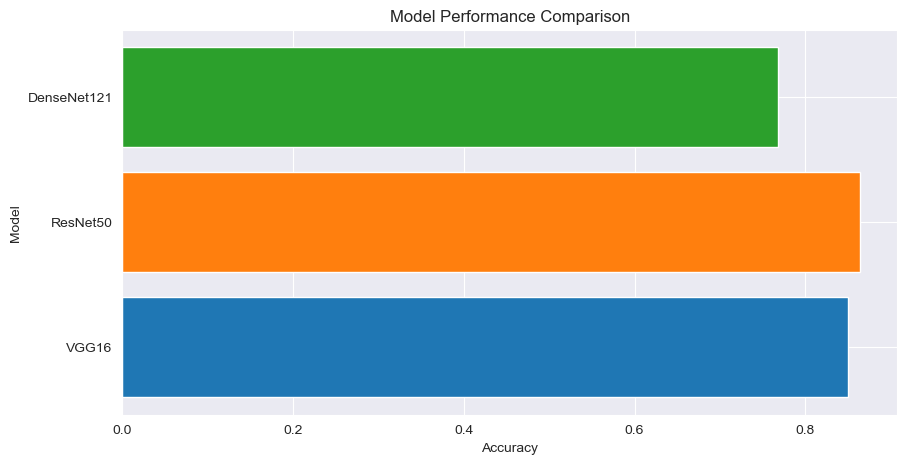

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sns.set_style("darkgrid")

models = [vgg16_finetuned_10e, resnet50_finetuned_10e, densenet121_finetuned_10e]
model_names = ["VGG16", "ResNet50", "DenseNet121"]

results = []

for model in models:
    results.append(model.evaluate(test_ds))

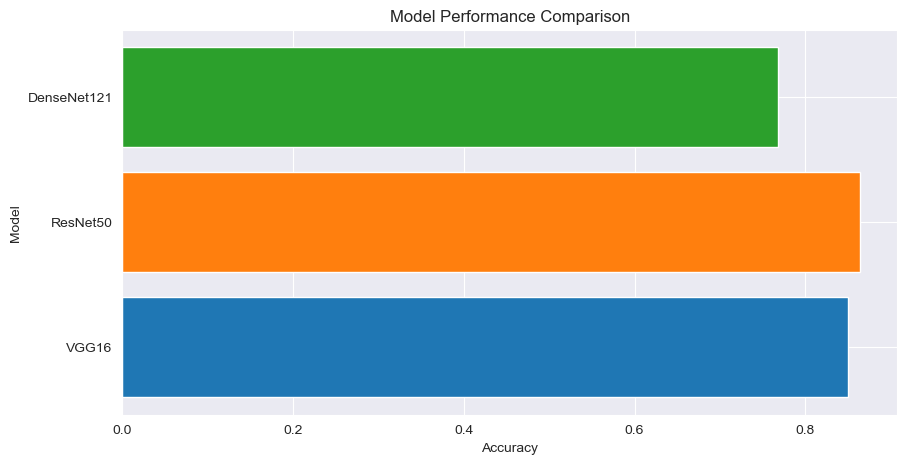

In [24]:
plt.figure(figsize=(10, 5))
plt.title("Model Performance Comparison")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.barh(model_names, [result[1] for result in results], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.show()